In [ ]:
# IS OPTIMAL TRANSPORT AN EFFECTIVE TOOL FOR DOMAIN ADAPTATION?

In [3]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader





In [4]:
dataset = get_dataset(dataset="poverty", download=True)

In [5]:
def tvt_split_index(ids, train_p, valid_p, random_seed=42):
    np.random.seed(random_seed)
    n = len(ids)
    np.random.shuffle(ids)
    train = ids[:int(n*train_p)]
    valid = ids[int(n*train_p):int(n*(train_p+valid_p))]
    test = ids[int(n*(train_p+valid_p)):]
    return train, valid, test

In [6]:
# target country
T_country = 'nigeria'

# set train, valid proportions
# test is the rest
train_p, valid_p = .7, .2

# 

import pandas as pd
import numpy as np

meta = pd.read_csv('./data/poverty_v1.1/dhs_metadata.csv')


T = meta[meta['country'] == T_country]

# Urban and rural split
T_u = T[T['urban'] == True]
T_r = T[T['urban'] == False]

T_u_i_train, T_u_i_valid, T_u_i_test = tvt_split_index(T_u.index.values, train_p, valid_p)
T_r_i_train, T_r_i_valid, T_r_i_test = tvt_split_index(T_r.index.values, train_p, valid_p)

In [44]:
for image, label, metadata in dataIterable(dataset, T_u_i_train, 100):
    print(image.shape)

torch.Size([100, 8, 224, 224])
torch.Size([100, 8, 224, 224])
torch.Size([100, 8, 224, 224])
torch.Size([100, 8, 224, 224])
torch.Size([10, 8, 224, 224])


In [5]:
# create iterable dataset given indicies

import torch

class dataIterable:
    def __init__(self, dataset, indicies, batch_size=1):
        
        self.dataset = dataset
        self.indicies = indicies
        self.i = 0
        self.bs = batch_size
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i < len(self.indicies):
            
            i = self.i
            self.i += self.bs
            return tuple([torch.stack([dataset[d][q] for d in range(i, min(i+self.bs, len(self.indicies)))]) for q in range(3)]+[torch.tensor(self.indicies[i:min(i+self.bs, len(self.indicies))])])
            
        else:
            raise StopIteration

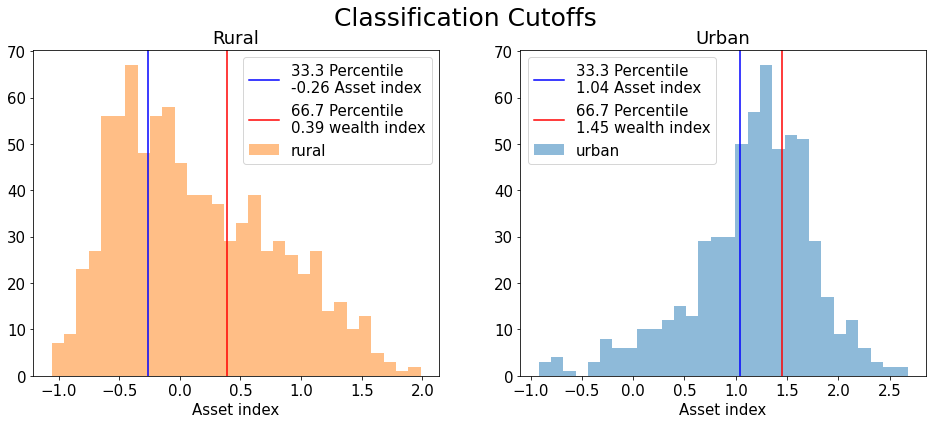

In [27]:
import matplotlib.pyplot as plt

# classification quantiles
low_quantile = 1/3
high_quantile = 2/3

# calculate borders based off quantile
u_low_cutoff, u_high_cutoff = T_u['wealthpooled'].quantile(low_quantile), T_u['wealthpooled'].quantile(high_quantile)
r_low_cutoff, r_high_cutoff = T_r['wealthpooled'].quantile(low_quantile), T_r['wealthpooled'].quantile(high_quantile)



#                     #
# ---- make plot ---- #
#                     #

plt.rcParams.update({'font.size': 15})

# subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# histogram
axs[1].hist(T_u['wealthpooled'], bins=30, alpha=0.5, label='urban')
axs[0].hist(T_r['wealthpooled'], bins=30, alpha=0.5, color='tab:orange', label='rural')

# low cutoff
axs[1].axvline(x=u_low_cutoff, color='blue', label=f'{round(low_quantile*100, 1)} Percentile\n{round(u_low_cutoff, 2)} Asset index')
axs[0].axvline(x=r_low_cutoff, color='blue', label=f'{round(low_quantile*100, 1)} Percentile\n{round(r_low_cutoff, 2)} Asset index')

# high cutoff
axs[1].axvline(x=u_high_cutoff, color='red', label=f'{round(high_quantile*100, 1)} Percentile\n{round(u_high_cutoff, 2)} Asset index')
axs[0].axvline(x=r_high_cutoff, color='red', label=f'{round(high_quantile*100, 1)} Percentile\n{round(r_high_cutoff, 2)} Asset index')

# legend
axs[1].legend()
axs[0].legend()

# subplot titles
axs[1].set_title("Urban")
axs[0].set_title("Rural")

# subplot x labels
axs[1].set_xlabel("Asset index")
axs[0].set_xlabel("Asset index")

fig.suptitle("Classification Cutoffs", fontsize='25')
fig.show()

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Neural Net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(8, 48, 3)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.conv3 = nn.Conv2d(96, 1, 1)
        
        self.fc1 = nn.Linear(2916, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x, meta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# put NN on GPU
if torch.cuda.is_available():
    net = net.cuda()
    
# Loss Function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [115]:
# data structure for logging training info
training_info = pd.DataFrame(
    {'train_loss': [],
     'valid_loss': [],
     'train_acc': [],
     'valid_acc': []
    }
)

# function to log training info
def log(train_loss, valid_loss, train_acc, valid_acc, to):
    new_row = pd.DataFrame({
        'train_loss': [train_loss],
         'valid_loss': [valid_loss],
         'train_acc': [train_acc],
         'valid_acc': [valid_acc]
    })
    
    return pd.concat([to, new_row], ignore_index=True)

In [116]:
batch_size = 64

for epoch in range(500):
    
    running_loss = 0.0
    batches = 0
    correct = 0
    count = 0
    for images, labels, metadata in dataIterable(dataset, T_r_i_train, batch_size):
        
        # classification labels based off on borders
        labels = torch.where(labels < r_low_cutoff, 0, torch.where(labels > r_high_cutoff, 2, 1)).flatten()
        
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), metadata.cuda()
            
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(images, meta)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        batches += 1
        correct += (labels == outputs.argmax(dim=1)).sum().item()
        count += outputs.shape[0]
        
    train_loss = running_loss/batches
    train_acc = correct/count
    
    
    
    running_loss = 0.0
    batches = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for images, labels, metadata in dataIterable(dataset, T_r_i_valid, batch_size):
            
            # classification labels based off on borders
            labels = torch.where(labels < r_low_cutoff, 0, torch.where(labels > r_high_cutoff, 2, 1)).flatten()
            
            # put data onto gpu if available
            if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), metadata.cuda()
                
            outputs = net(images, meta)
            
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            batches += 1
            correct += (labels == outputs.argmax(dim=1)).sum().item()
            count += outputs.shape[0]
    valid_loss = running_loss/batches
    valid_acc = correct/count
    
    
    training_info = log(train_loss, valid_loss, train_acc, valid_acc, training_info)
    
    torch.save(net, f'../models/rural/CNN_epoch_{epoch:03d}')
    
    print(training_info.iloc[[-1]])

   train_loss  valid_loss  train_acc  valid_acc
0    1.115699    1.109996   0.099338   0.115607
   train_loss  valid_loss  train_acc  valid_acc
1    1.102481    1.100312   0.206954   0.271676
   train_loss  valid_loss  train_acc  valid_acc
2    1.075751    1.079928   0.519868   0.289017
   train_loss  valid_loss  train_acc  valid_acc
3    0.983153    1.041991   0.528146   0.283237
   train_loss  valid_loss  train_acc  valid_acc
4    0.825004    1.044374    0.52649   0.283237
   train_loss  valid_loss  train_acc  valid_acc
5    0.783174    0.975714    0.52649   0.283237
   train_loss  valid_loss  train_acc  valid_acc
6    0.752942    0.945533   0.592715   0.572254
   train_loss  valid_loss  train_acc  valid_acc
7       0.732    0.929471   0.721854   0.641618
   train_loss  valid_loss  train_acc  valid_acc
8    0.712211    0.915599   0.743377   0.693642
   train_loss  valid_loss  train_acc  valid_acc
9    0.695786      0.9002   0.778146   0.728324
    train_loss  valid_loss  train_acc  v

    train_loss  valid_loss  train_acc  valid_acc
84    0.407386    0.472275   0.874172   0.843931
    train_loss  valid_loss  train_acc  valid_acc
85    0.401506    0.470654   0.872517   0.843931
    train_loss  valid_loss  train_acc  valid_acc
86    0.396533    0.473253   0.877483   0.843931
    train_loss  valid_loss  train_acc  valid_acc
87     0.40036    0.440354   0.872517   0.855491
    train_loss  valid_loss  train_acc  valid_acc
88    0.380073    0.467871   0.880795   0.849711
    train_loss  valid_loss  train_acc  valid_acc
89    0.390094    0.437521   0.879139   0.855491
    train_loss  valid_loss  train_acc  valid_acc
90    0.373269     0.45178    0.88245   0.849711
    train_loss  valid_loss  train_acc  valid_acc
91    0.377878    0.433271   0.877483   0.855491
    train_loss  valid_loss  train_acc  valid_acc
92    0.367142    0.436833   0.880795   0.855491
    train_loss  valid_loss  train_acc  valid_acc
93    0.364883     0.43571    0.88245   0.855491
    train_loss  vali

     train_loss  valid_loss  train_acc  valid_acc
167    0.376061    0.354276   0.895695   0.890173
     train_loss  valid_loss  train_acc  valid_acc
168    0.305001    0.433787   0.912252   0.872832
     train_loss  valid_loss  train_acc  valid_acc
169    0.294541    0.301182   0.907285   0.890173
     train_loss  valid_loss  train_acc  valid_acc
170    0.246152    0.283938   0.912252   0.924855
     train_loss  valid_loss  train_acc  valid_acc
171    0.232817    0.280867   0.925497   0.919075
     train_loss  valid_loss  train_acc  valid_acc
172    0.224623    0.272009   0.923841   0.924855
     train_loss  valid_loss  train_acc  valid_acc
173    0.216304     0.28388   0.933775   0.901734
     train_loss  valid_loss  train_acc  valid_acc
174    0.219261    0.263262   0.933775   0.924855
     train_loss  valid_loss  train_acc  valid_acc
175     0.21155     0.26632    0.93543   0.919075
     train_loss  valid_loss  train_acc  valid_acc
176    0.209208    0.259321    0.93543   0.936416


     train_loss  valid_loss  train_acc  valid_acc
249    0.275601    0.305874   0.905629   0.924855
     train_loss  valid_loss  train_acc  valid_acc
250    0.245385    0.296047   0.925497   0.907514
     train_loss  valid_loss  train_acc  valid_acc
251    0.241533    0.393165   0.928808   0.867052
     train_loss  valid_loss  train_acc  valid_acc
252    0.279619    0.292714    0.90894   0.924855
     train_loss  valid_loss  train_acc  valid_acc
253    0.242199    0.286255   0.928808   0.919075
     train_loss  valid_loss  train_acc  valid_acc
254    0.231392    0.353369    0.93543   0.872832
     train_loss  valid_loss  train_acc  valid_acc
255     0.25783      0.2915   0.912252   0.913295
     train_loss  valid_loss  train_acc  valid_acc
256    0.242963    0.314543   0.928808   0.919075
     train_loss  valid_loss  train_acc  valid_acc
257    0.344191    0.482154   0.915563   0.861272
     train_loss  valid_loss  train_acc  valid_acc
258    0.393028    0.698135   0.877483   0.867052


     train_loss  valid_loss  train_acc  valid_acc
331    0.097527    0.113439   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
332    0.096415    0.112162   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
333    0.095299    0.110943   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
334    0.094207    0.109758   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
335    0.093121    0.108575   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
336    0.092033    0.107453   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
337    0.090972    0.106353   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
338    0.089926     0.10523   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
339    0.088891    0.104154   0.976821   0.976879
     train_loss  valid_loss  train_acc  valid_acc
340    0.087877    0.103091   0.976821   0.976879


     train_loss  valid_loss  train_acc  valid_acc
413    0.946057    1.013794    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
414    0.945677     1.01416    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
415    0.945372    1.015254    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
416    0.945268    1.015723    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
417    0.945143    1.015974    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
418    0.944969    1.016445    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
419    0.944823    1.016961    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
420    0.944708    1.017381    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
421    0.944596    1.017778    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
422    0.944486    1.018193    0.52649   0.283237


     train_loss  valid_loss  train_acc  valid_acc
495    0.942751    1.027706    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
496    0.942745    1.027721    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
497    0.942739    1.027736    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
498    0.942734    1.027749    0.52649   0.283237
     train_loss  valid_loss  train_acc  valid_acc
499    0.942728    1.027761    0.52649   0.283237


In [113]:
# BEST URBAN: 317
# BEST RURAL: 361

<AxesSubplot:>

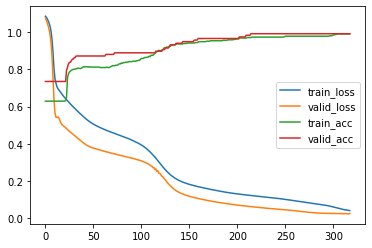

In [111]:
training_info.iloc[:318].plot()

<AxesSubplot:>

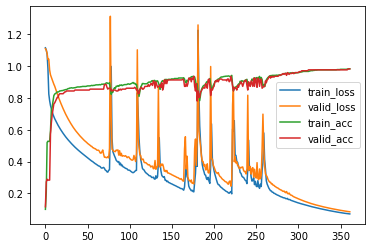

In [140]:
training_info.iloc[:362].plot()

In [75]:
nut = pd.read_csv(f'../models/nigeria/urban/training_info.csv', index_col=0)
nrt = pd.read_csv(f'../models/nigeria/rural/training_info.csv', index_col=0)

<AxesSubplot:title={'center':'Nigeria Rural Training Info'}, xlabel='epoch'>

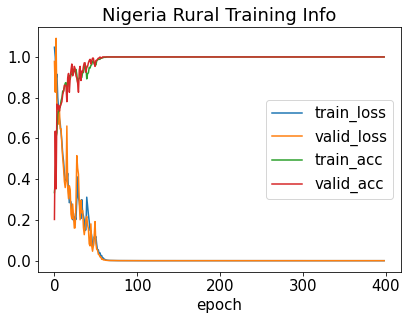

In [76]:
nrt.iloc[:nrt['valid_loss'].idxmin()].plot(figsize=(6.5, 4.5), xlabel='epoch', title='Nigeria Rural Training Info')

<AxesSubplot:title={'center':'Nigeria Urban Training Info'}, xlabel='epoch'>

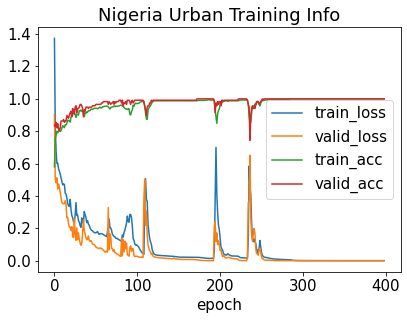

In [78]:
nut.iloc[:nut['valid_loss'].idxmin()].plot(figsize=(6.5, 4.5), xlabel='epoch', title='Nigeria Urban Training Info')

In [7]:
atn = pd.read_csv('../results/angola_to_nigeria.csv')
mtn = pd.read_csv('../results/mali_to_nigeria.csv')
#btn = pd.read_csv('../results/burkina_faso_to_nigeria.csv')
#ltn = pd.read_csv('../results/lesotho_to_nigeria.csv')

In [228]:
mtn['actual'].replace([2, 1, 0], ["poor", 'moderate', 'wealthy'], inplace=True)
mtn['predicted'].replace([2, 1, 0], ["poor", 'moderate', 'wealthy'], inplace=True)

In [8]:
mtn[mtn['urban']==True][mtn['transport']==True].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count', sort=True).fillna(0).astype(int)[['wealthy', 'moderate', 'poor']].iloc[[2, 0, 1]]

/tmp/ipykernel_15452/1887692408.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mtn[mtn['urban']==True][mtn['transport']==True].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count', sort=True).fillna(0).astype(int)[['wealthy', 'moderate', 'poor']].iloc[[2, 0, 1]]


KeyError: "None of [Index(['wealthy', 'moderate', 'poor'], dtype='object', name='actual')] are in the [columns]"

actual     wealthy  moderate  poor
predicted                         
wealthy        173         0     1
moderate         0        43     0
poor             0         0   212

In [28]:
v = mtn[mtn['urban']==True].pivot_table(index='id', columns='transport', values=['predicted', 'actual'], aggfunc=sum)
v[v['predicted'][False] != v['predicted'][True]]

actual      predicted     
transport  False True     False True
id                                  
10653          1    1         1    0
10677          1    1         1    0
10678          2    2         2    0
10679          2    2         2    0

In [72]:
df = mtn
df = df.replace([2, 1, 0], ["poor", 'moderate', 'wealthy'])
df = df.pivot_table(index='id', columns='transport', values=['predicted', 'actual'], aggfunc=sum)
df = df[df['predicted'][False] != df['predicted'][True]]
a = df['actual'][False]
p = pd.DataFrame({
    'actual': df['actual'][False],
    'without_OT': df['predicted'][False],
    'with_OT': df['predicted'][True]
})

s = p.sample()
print(s.head())
imid = s.index.values[0]
imid

         actual without_OT  with_OT
id                                 
10677  moderate   moderate  wealthy


10677

In [107]:
import ot
import os
def load_sinkhorn(path):
    sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    sinkhorn.coupling_ = torch.load(os.path.join(path, 'coupling.pt'))
    sinkhorn.xt_ = torch.load(os.path.join(path, 'xt.pt'))
    sinkhorn.xs_ = torch.load(os.path.join(path, 'xs.pt'))
    sinkhorn.nx = sinkhorn._get_backend(sinkhorn.xs_, None, sinkhorn.xt_, None)
    return sinkhorn

In [245]:
def show_channels_id(id, figsize=(30, 15)):
    fig, axs = plt.subplots(2, 4, figsize=figsize)

    channels = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
    
    for i in range(8):
        axs[i//4][i%4].imshow(dataset[id][0][i])
        axs[i//4][i%4].set_title(channels[i])
    
    print(f'wealth index: {dataset[id][1][0]}')

In [247]:
def show_channels_im(im, figsize=(30, 15)):
    fig, axs = plt.subplots(2, 4, figsize=figsize)

    channels = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
    
    for i in range(8):
        axs[i//4][i%4].imshow(im[0][i])
        axs[i//4][i%4].set_title(channels[i])

In [248]:
def show_image(id, title=None):
    # definitely not accurate...
    plt.imshow((torch.stack([dataset[id][0][2], dataset[id][0][1], dataset[id][0][0]], dim=2)+1.2290)/(2.6758+1.2290))
    plt.title(title)
    
    print(f'wealth index: {dataset[id][1][0]}')

In [249]:
def transport_images(images, sinkhorn):
    shape = images.shape
    for batch in range(shape[0]):
        for row in range(shape[2]):
            images[batch, :, row, :] = sinkhorn.transform(images[batch, :, row, :].T).T

In [171]:
mtn_ot = load_sinkhorn('../results/mali_to_nigeria')

In [250]:
def compare_ot_and_not(imid, sinkhorn):
    
    print("Transporting image...")
    im = dataset[imid][0][None, :, :, :].clone()
    transport_images(im, atn_ot)
    
    print("OT")
    plt.imshow((torch.stack([im[0][2], im[0][1], im[0][0]], dim=2)+1.2290)/(2.6758+1.2290))
    plt.title("RGB")
    plt.show()
    print("no OT")
    show_image(imid, title="RGB")
    plt.show()
    print("OT")
    show_channels_im(im)
    plt.show()
    print("no OT")
    show_channels_id(imid)
    plt.show()

Transporting image...
OT


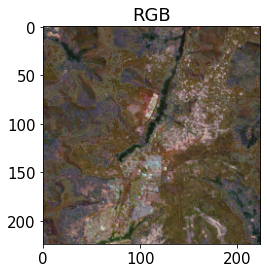

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no OT
wealth index: 1.1882357597351074


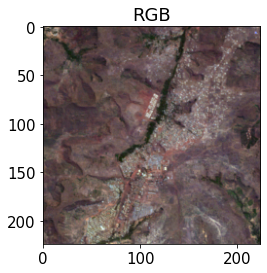

OT


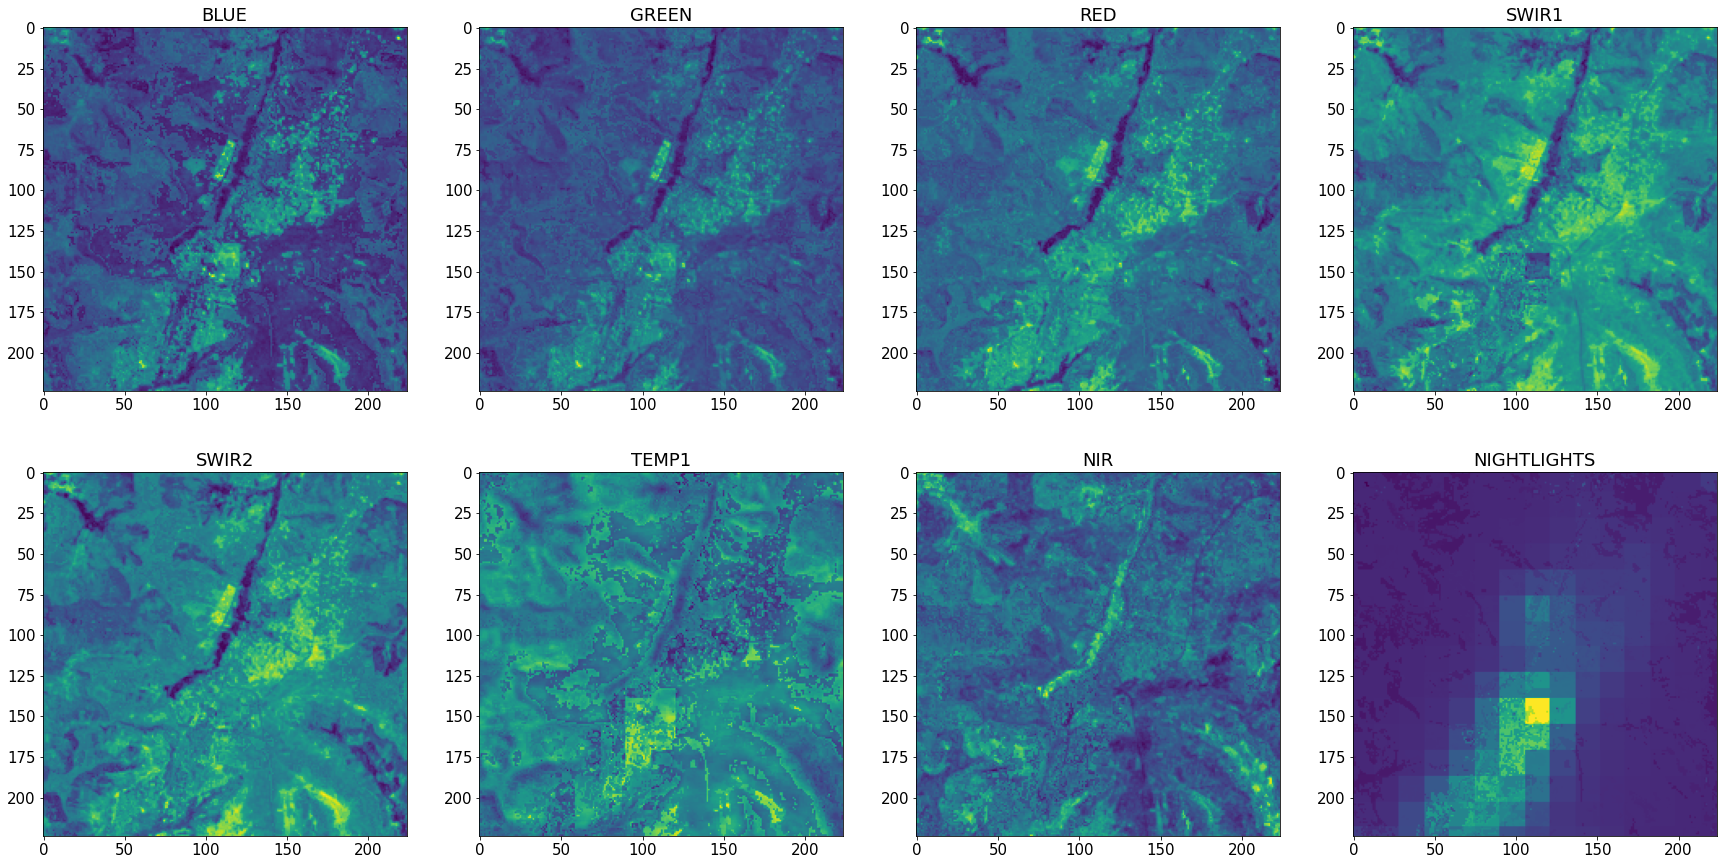

no OT
wealth index: 1.1882357597351074


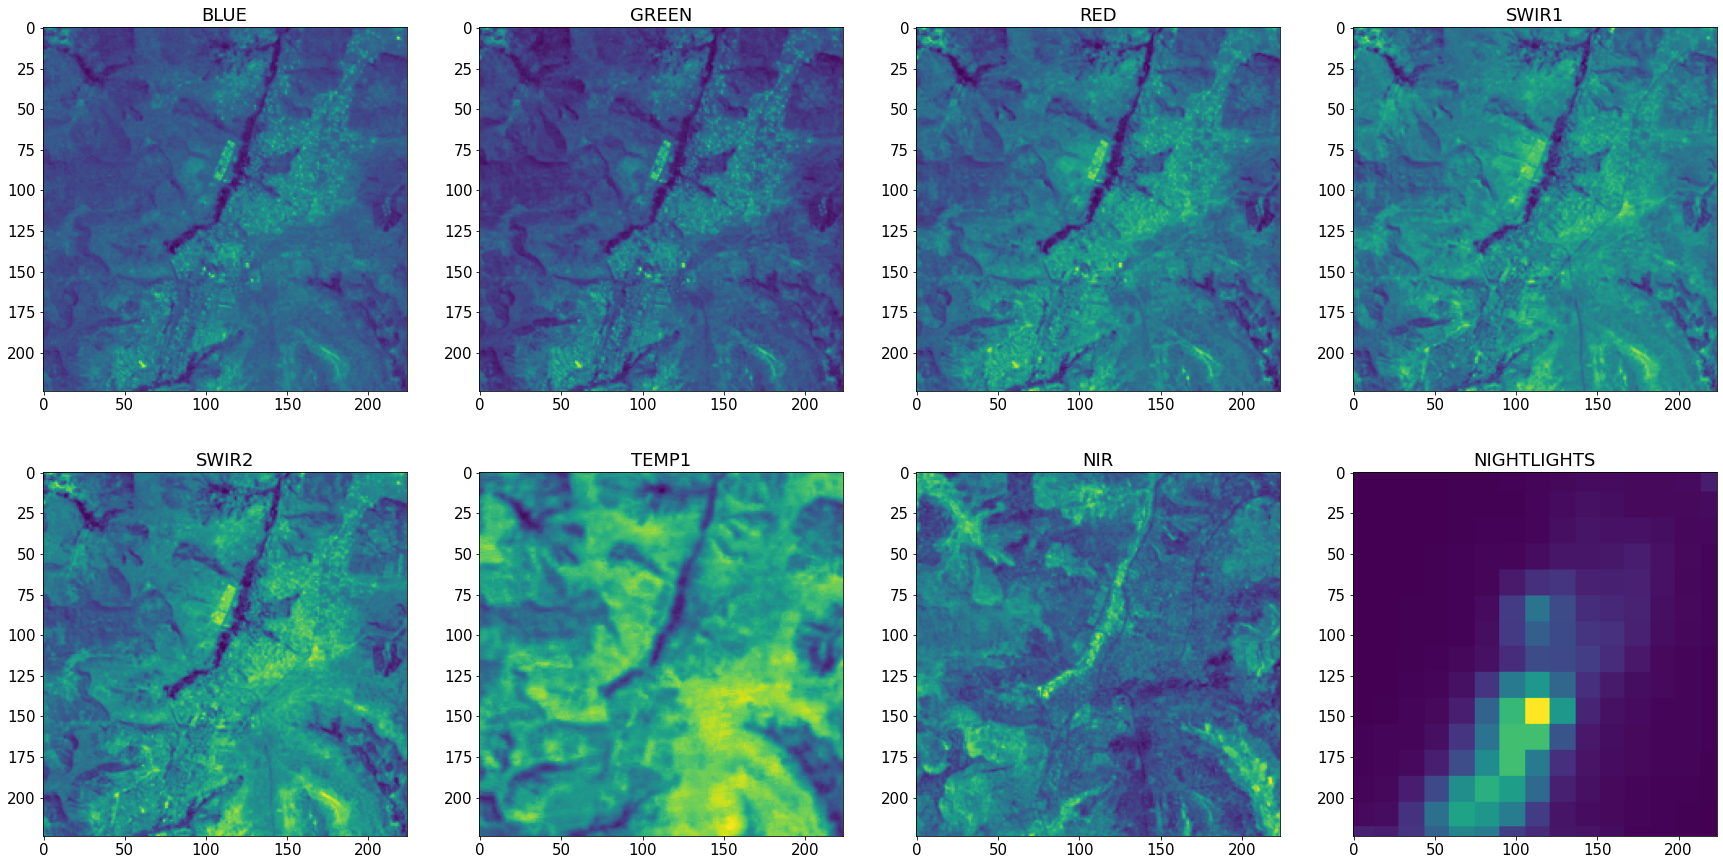

In [251]:
compare_ot_and_not(10653, mtn_ot)

Transporting image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OT


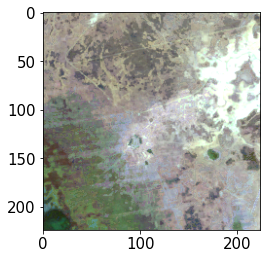

no OT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wealth index: -0.34730055928230286


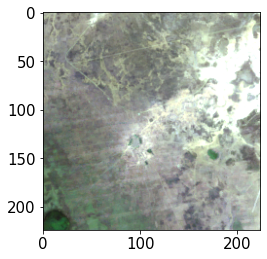

OT


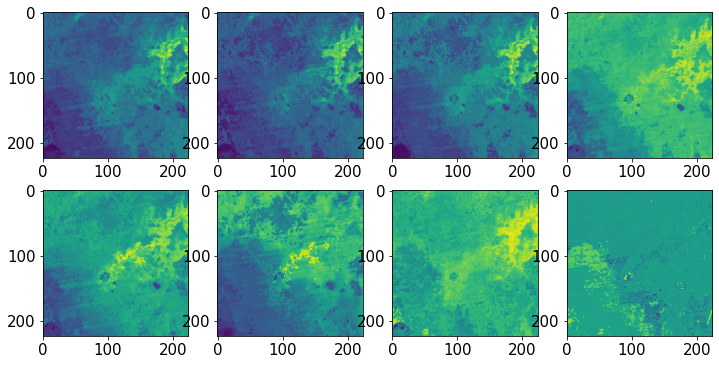

no OT
wealth index: -0.34730055928230286


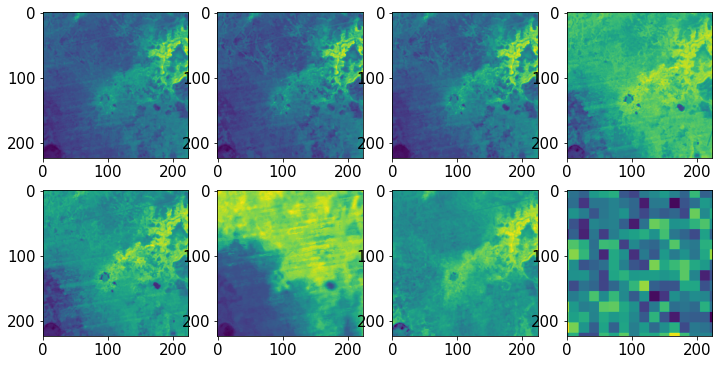

In [174]:
compare_ot_and_not(10677, mtn_ot)

Transporting image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OT


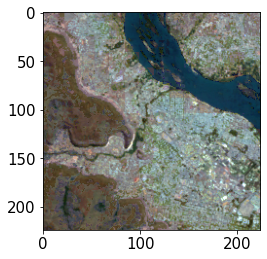

no OT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wealth index: 0.9348052740097046


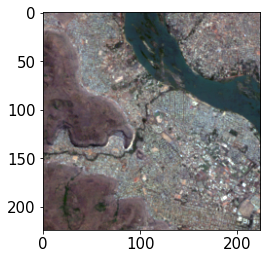

OT


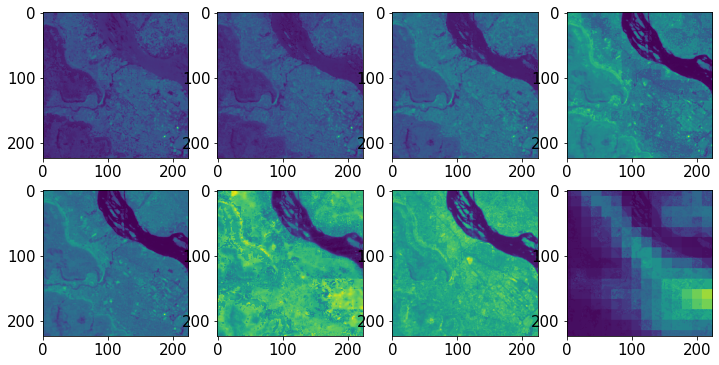

no OT
wealth index: 0.9348052740097046


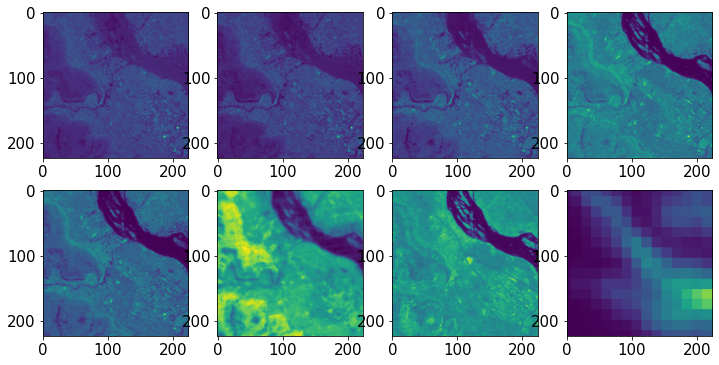

In [175]:
compare_ot_and_not(10678, mtn_ot)

Transporting image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OT


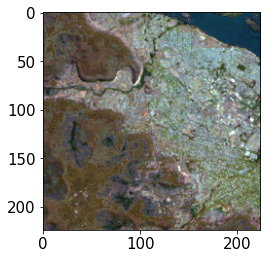

no OT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wealth index: 1.5817794799804688


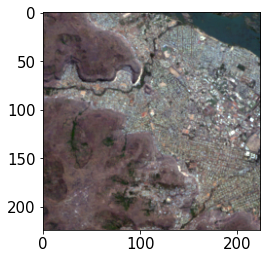

OT


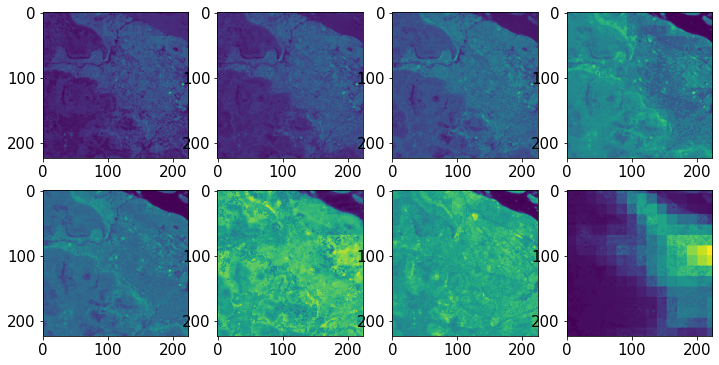

no OT
wealth index: 1.5817794799804688


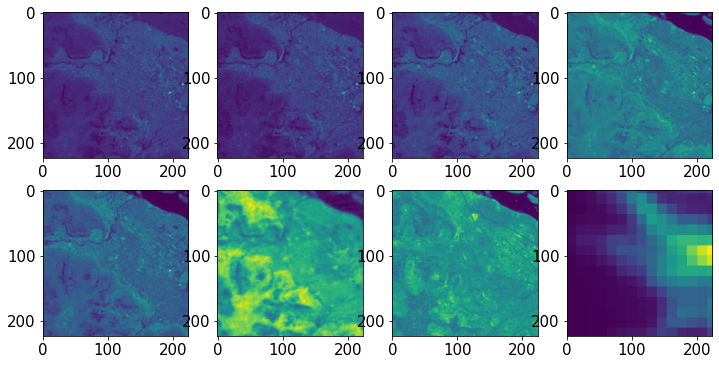

In [176]:
compare_ot_and_not(10679, mtn_ot)

Transporting image...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


OT


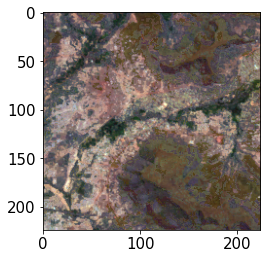

no OT


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


wealth index: 1.672580599784851


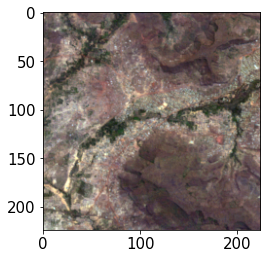

OT


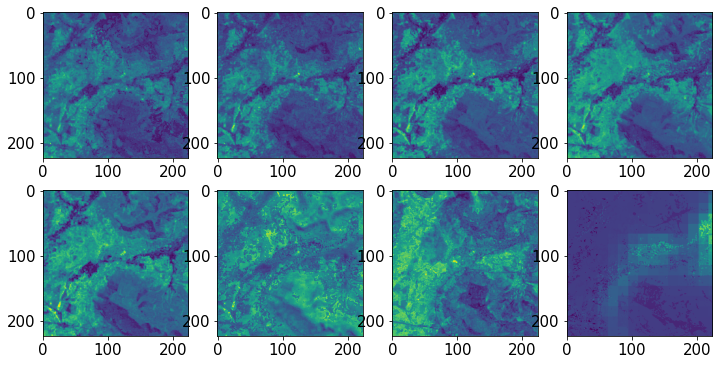

no OT
wealth index: 1.672580599784851


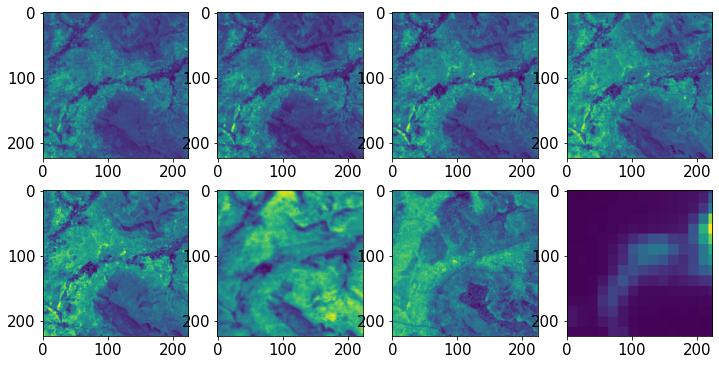

In [177]:
compare_ot_and_not(10654, mtn_ot)